In [238]:
dc_codes = None
ac_codes = None
encoded_dc = None
encoded_ac = None
height = None
width = None

232392
['00011100', '00000101', '00001000', '01110110', '11010101', '00011000', '00000110', '00000101', '01000111', '00101001']
{'height': 304, 'width': 304, 'dc_codes': {-139: '0000000000', 1060: '0000000001', 217: '0000000010', -753: '0000000011', -207: '0000000100', -45: '0000000101', -204: '0000000110', -122: '0000000111', 17: '0000001000', 548: '0000001001', -52: '000000101', 273: '000000110', 174: '0000001110', 3: '0000001111', 27: '0000010', 110: '0000011', 435: '0000100000', 989: '0000100001', -93: '0000100010', -75: '0000100011', 166: '0000100100', 175: '0000100101', 381: '0000100110', 756: '0000100111', -490: '0000101000', 792: '0000101001', 121: '0000101010', -477: '0000101011', 647: '000010110', 95: '0000101110', -324: '0000101111', -509: '00001100', 275: '0000110100', 743: '0000110101', -134: '000011011', 53: '000011100', -840: '000011101', 32: '0000111100', -177: '0000111101', 861: '0000111110', -521: '0000111111', -812: '000100000', -39: '0001000010', -103: '0001000011',

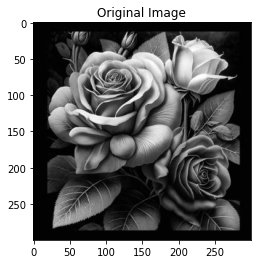

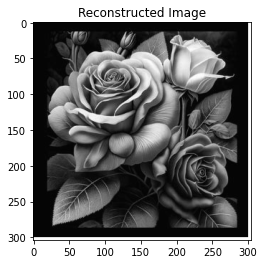

(300, 300, 3)
[-577, -10, 234, -114, -42, 413, -27, 27, 205, -461, -619, 1265, -1265, 0, 343, 229, -137, -41, 137, 454, 82, -178, 385, -647, 124, 165, 124, -164, -455, 96, -82, -110, -95, 933, 42, -921, 124, 96, 192, 111, 0, -424, -17, 495, 344, -589, -437, 110, -289, 1265]
[414, 404, 638, 524, 482, 895, 868, 895, 1100, 639, 20, 1285, 20, 20, 363, 592, 455, 414, 551, 1005, 1087, 909, 1294, 647, 771, 936, 1060, 896, 441, 537, 455, 345, 250, 1183, 1225, 304, 428, 524, 716, 827, 827, 403, 386, 881, 1225, 636, 199, 309, 20, 1285]
1443
Indices where old_enc and new_enc differ: [   1    2    3 ... 1441 1442 1443]


In [290]:
import cv2
import numpy as np
import math
import heapq
from collections import Counter
import matplotlib.pyplot as plt

old_quant = None
old_enc = None
new_enc = None
new_quant = None
class HuffmanNode:
    """Class for a node in the Huffman tree."""
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq


class JPEGCodec:
    """Class to perform JPEG compression and decompression."""
    def __init__(self):
        self.Q_50_matrix = np.array([
            [16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 25, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]
        ], dtype=float)
        self.zigzag_order = [
            0,  1,  5,  6, 14, 15, 27, 28,
            2,  4,  7, 13, 16, 26, 29, 42,
            3,  8, 12, 17, 25, 30, 41, 43,
            9, 11, 18, 24, 31, 40, 44, 53,
           10, 19, 23, 32, 39, 45, 52, 54,
           20, 22, 33, 38, 46, 51, 55, 60,
           21, 34, 37, 47, 50, 56, 59, 61,
           35, 36, 48, 49, 57, 58, 62, 63,
        ]

    @staticmethod
    def compute_size(value):
        """Compute the size of a value."""
        if value == 0:
            return 0
        return int(np.floor(np.log2(abs(value))) + 1)

    def zigzag_flatten(self, block):
        """Flatten an 8x8 block in zigzag order."""
        flat = block.flatten()
        return [flat[idx] for idx in self.zigzag_order]


    @staticmethod
    def build_huffman_tree(frequencies):
        """Build a Huffman tree from frequency data."""
        heap = [HuffmanNode(symbol, freq) for symbol, freq in frequencies.items()]
        heapq.heapify(heap)
        while len(heap) > 1:
            node1 = heapq.heappop(heap)
            node2 = heapq.heappop(heap)
            merged = HuffmanNode(None, node1.freq + node2.freq)
            merged.left = node1
            merged.right = node2
            heapq.heappush(heap, merged)
        return heap[0]

    @staticmethod
    def generate_huffman_codes(node, code="", codebook=None):
        """Generate Huffman codes from a Huffman tree."""
        if codebook is None:
            codebook = {}  # Initialize a new dictionary if none is provided

        if node is not None:
            if node.symbol is not None:  # Leaf node
                codebook[node.symbol] = code
            JPEGCodec.generate_huffman_codes(node.left, code + "0", codebook)
            JPEGCodec.generate_huffman_codes(node.right, code + "1", codebook)

        return codebook

    @staticmethod
    def build_huffman_decoding_map(codes):
        """Build a decoding map from Huffman codes."""
        return {code: symbol for symbol, code in codes.items()}

    def to_grayscale(self, image):
        """
        Convert the input image to grayscale.
        If the image is already single-channel, return it as-is.
        """
        if len(image.shape) == 3:  # Color image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return image

    def pad_image(self, image):
        """
        Pad the grayscale image to make its dimensions a multiple of 8.
        """
        padded_height = (image.shape[0] // 8 + 1) * 8
        padded_width = (image.shape[1] // 8 + 1) * 8
        padded_image = np.full((padded_height, padded_width), 255, dtype=image.dtype)  # Default pad with 255
        padded_image[:image.shape[0], :image.shape[1]] = image
        return padded_image

    def quantize_image(self, padded_image, quality=50):
        """
        Divide the image into 8x8 blocks, apply DCT, and quantize the coefficients.
        """
        quantized_matrix = np.zeros_like(padded_image, dtype=int)
        height, width = padded_image.shape

        q_matrix = (50 / quality) * self.Q_50_matrix  # Adjust quantization matrix based on quality

        for i in range(0, height, 8):
            for j in range(0, width, 8):
                block = padded_image[i:i+8, j:j+8]
                dct_block = cv2.dct(block.astype(float))
                quantized_matrix[i:i+8, j:j+8] = np.round(dct_block / q_matrix)
        return quantized_matrix


    def jpeg_huffman_encode(self, quantized_matrix):
        """Perform Huffman encoding on quantized coefficients."""
        height, width = quantized_matrix.shape
        dc_differences = []
        ac_symbols = []

        previous_dc = 0
        flat_blocks = []
        global old_enc
        old_enc = []

        for i in range(0, height, 8):
            for j in range(0, width, 8):
                block = quantized_matrix[i:i+8, j:j+8]
                flat = self.zigzag_flatten(block)
                flat_blocks.append(flat)

                # DC coefficient
                dc = flat[0]
                dc_diff = dc - previous_dc
                dc_differences.append(dc_diff)
                old_enc.append(dc_diff)
                previous_dc = dc

                # AC coefficients
                run_length = 0
                last_non_zero = -1
                for coef in range(len(flat)-1, 0, -1):
                    if(flat[coef]!=0):
                        last_non_zero = coef
                        break
                if(last_non_zero==-1):
                    ac_symbols.append((0, 0, 0))
                else: 
                    for coef in flat[1:last_non_zero+1]:
                        if coef == 0:
                            run_length += 1
                            if run_length == 16:  # Max run-length encoding
                                ac_symbols.append((15, 0, 0))
                                run_length = 0
                        else:
                            ac_symbols.append((run_length, 0, coef))
                            run_length = 0
                    if last_non_zero != 63:
                        ac_symbols.append((0, 0, 0))  # End of block
        self.temp = dc_differences 
        # Create frequency tables
        dc_frequencies = Counter(dc_differences)
        ac_frequencies = Counter([val[2] if len(val)==3 else val[1] for val in ac_symbols ])
        
        # Build Huffman trees
        dc_tree = self.build_huffman_tree(dc_frequencies)
        ac_tree = self.build_huffman_tree(ac_frequencies)

        # Generate Huffman codes
        dc_codes = self.generate_huffman_codes(dc_tree)
        ac_codes = self.generate_huffman_codes(ac_tree)

        # Encode data
        encoded_dc = [dc_codes[diff] for diff in dc_differences]
        encoded_ac = [(symbol[0], len(ac_codes[symbol[2]]), ac_codes[symbol[2]]) if len(symbol)==3 else (symbol[0], ac_codes[symbol[1]]) for symbol in ac_symbols]
        return dc_codes, ac_codes, encoded_dc, encoded_ac

    # Reverse zigzag to reconstruct 8x8 blocks
    def reverse_zigzag(self, flattened_block):
        """Reconstruct an 8x8 block from a zigzag flattened block."""
        block = np.zeros(64, dtype=int)
        for i, idx in enumerate(self.zigzag_order):
            block[idx] = flattened_block[i]
        return block.reshape(8, 8)

    # Build a Huffman decoding map from the codes
    def build_huffman_decoding_map(self, codes):
        decoding_map = {}
        for symbol, code in codes.items():
            decoding_map[code] = symbol
        return decoding_map

    # Decode Huffman-encoded data using the decoding map
    def decode_huffman_data(self, encoded_data, decoding_map):
        current_code = ""
        decoded_symbols = []
        for element in encoded_data:
            current_code += str(element)
            if current_code in decoding_map:
                decoded_symbols.append(decoding_map[current_code])
                current_code = ""
        if(current_code != ""):
            print("Encoded bit not present in map")
            pass
            # raise RuntimeWarning("Encoded bit not present in map")
        return decoded_symbols

    # Decode DC coefficients
    def decode_dc_coefficients(self, encoded_dc, dc_decoding_map):
        dc_differences = self.temp #self.decode_huffman_data(encoded_dc, dc_decoding_map)
        # min_index = 2170
        # max_index = 2170
        # print(dc_differences[2170:2180])
        # print(encoded_dc[2170:2180])
        #encoded_dc = "".join([str(el) for el in encoded_dc])
        dc_differences = self.decode_huffman_data(encoded_dc, dc_decoding_map)### Uncomment this for actual result
        # unequal_elements = [(i, self.temp[i], dc_differences[i]) for i in range(len(self.temp)) if self.temp[i] != dc_differences[i]]
        # print("Unequal elements (index, self.temp, dc_differences):", unequal_elements)
        # print(dc_differences[2170:2180])
        # input()
        dc_coefficients = []
        global new_enc
        new_enc = []
        previous_dc = 0
        # print(dc_differences[900:950])
        count = 0
        for diff in dc_differences:
            current_dc = previous_dc + diff
            if(count<100):
                count+=1
            dc_coefficients.append(current_dc)
            previous_dc = current_dc
            new_enc.append(current_dc)
        # print(dc_coefficients[900:950])
        return dc_coefficients

    # Decode AC coefficients
    def decode_ac_coefficients(self, encoded_ac, ac_decoding_map):
        encoded_ac_values = [symbol[-1] for symbol in encoded_ac]
        ac_values_symbols = self.decode_huffman_data(encoded_ac_values, ac_decoding_map)
        ac_symbols = [(encoded_ac[i][0], encoded_ac[i][1], ac_values_symbols[i]) if len(encoded_ac[i])==3 else (encoded_ac[i][0], ac_values_symbols[i]) for i in range(len(ac_values_symbols))]
        ac_coefficients = []
        refresh = 0
        count_of_block = 0
        print(ac_symbols[:100])
        for symbol in ac_symbols:
            if (symbol[0]==0 and symbol[-1]==0):  # End-of-block (EOB)
                while count_of_block < 63:
                    ac_coefficients.append(0)
                    count_of_block+=1
                count_of_block = 0
                refresh+=1
            else:
                run_length, size, value = symbol
                ac_coefficients.extend([0] * run_length)
                ac_coefficients.append(value)
                count_of_block+= (1+run_length)
                if(count_of_block==63):
                    count_of_block = 0
                    refresh+=1
        print("Refresh = ", refresh)
        return ac_coefficients

    # Reconstruct the quantized coefficients matrix
    def reconstruct_quantized_matrix(self, dc_coefficients, ac_coefficients, height, width):
        matrix = np.zeros((height, width), dtype=int)
        block_index = 0
        ac_index = 0
        for i in range(0, height, 8):
            for j in range(0, width, 8):
                # Initialize block with zeros
                block = np.zeros(64, dtype=int)

                # Set DC coefficient
                block[0] = dc_coefficients[block_index]

                # Set AC coefficients
                for k in range(1, 64):
                    block[k] = ac_coefficients[ac_index]
                    ac_index += 1

                # Reverse zigzag to reconstruct the block
                block_2d = self.reverse_zigzag(block)
                matrix[i:i+8, j:j+8] = block_2d

                block_index += 1

        return matrix

    # Main function to decode the Huffman-encoded data
    def jpeg_huffman_decode(self, dc_codes, ac_codes, encoded_dc, encoded_ac, height, width):
        # Build Huffman decoding maps
        dc_decoding_map = self.build_huffman_decoding_map(dc_codes)
        ac_decoding_map = self.build_huffman_decoding_map(ac_codes)

        # Decode DC coefficients
        dc_coefficients = self.decode_dc_coefficients(encoded_dc, dc_decoding_map)

        # Decode AC coefficients
        ac_coefficients = self.decode_ac_coefficients(encoded_ac, ac_decoding_map)

        # Reconstruct quantized coefficients matrix
        quantized_matrix = self.reconstruct_quantized_matrix(dc_coefficients, ac_coefficients, height, width)

        return quantized_matrix
    
    def reconstruct_image(self, reconstructed_matrix, quality):
        """
        Reconstruct an image from its quantized DCT coefficients.
        
        Args:
            reconstructed_matrix (ndarray): Quantized DCT coefficients matrix.
            q_matrix (ndarray): Quantization matrix used during encoding.

        Returns:
            ndarray: Reconstructed image.
        """
        height, width = reconstructed_matrix.shape
        reconstructed_image = np.zeros((height, width))

        q_matrix = (50 / quality) * self.Q_50_matrix  # Adjust quantization matrix based on quality
        global new_quant
        new_quant = np.zeros((height, width))
        for i in range(0, height, 8):
            for j in range(0, width, 8):
                block = reconstructed_matrix[i:i+8, j:j+8]
                iquan_coef = np.zeros((8, 8))
                
                # Dequantize the block
                for m in range(8):
                    for n in range(8):
                        iquan_coef[m, n] = block[m, n] * q_matrix[m, n]
                new_quant[i:i+8, j:j+8] = iquan_coef
                # Apply inverse DCT to the block
                reconstructed_image[i:i+8, j:j+8] = cv2.idct(iquan_coef)

        return reconstructed_image
    
    def encode_dc_encoded(self, dc_encoded):
        """Encodes the dc_encoded list of bit strings into bytes."""
        # Combine all bit strings into one
        combined_bits = ''.join(dc_encoded)
        
        # Calculate padding needed to make the length a multiple of 8
        padding_length = (8 - len(combined_bits) % 8) % 8
        combined_bits += '0' * padding_length  # Add zero-padding

        # Convert the padded bit string to bytes
        encoded_bytes = bytearray()
        for i in range(0, len(combined_bits), 8):
            byte = int(combined_bits[i:i+8], 2)  # Convert 8-bit chunks to integers
            encoded_bytes.append(byte)

        return encoded_bytes

    def encode_to_bytes_full(self, dc_codes, ac_codes, dc_encoded, ac_encoded, height, width):
        """
        Encode the given data into bytes including dc_encoded and ac_encoded.

        Args:
            height (int): Image height.
            width (int): Image width.
            dc_codes (dict): Dictionary mapping integers to bit streams for DC codes.
            ac_codes (dict): Dictionary mapping integers to bit streams for AC codes.
            dc_encoded (str): Huffman-encoded bit stream for DC coefficients.
            ac_encoded (list): List of tuples for AC encoding.
                Each tuple contains:
                - run_length (int): Run-length of zeros before a coefficient.
                - size (int): Size of the coefficient.
                - value (str): Huffman-encoded bit stream for the coefficient.

        Returns:
            bytes: Encoded byte sequence.
        """
        import struct

        # Helper to convert a bit string to bytes
        def bits_to_bytes(bit_string):
            num_bits = len(bit_string)
            byte_array = bytearray()
            for i in range(0, num_bits, 8):
                byte_chunk = bit_string[i:i+8]
                byte_array.append(int(byte_chunk.ljust(8, '0'), 2))  # Pad the last byte with zeros if necessary
            return byte_array

        encoded_data = bytearray()

        # 1. Store height (2 bytes) and width (2 bytes)
        encoded_data.extend(struct.pack(">H", height))  # Unsigned 2-byte integer, big-endian
        encoded_data.extend(struct.pack(">H", width))

        # 2. Encode DC codes
        
        encoded_data.extend(struct.pack(">I", len(dc_codes)))  # Number of DC dictionary elements
        for key, bit_stream in dc_codes.items():
            # Key as 2 bytes
            encoded_data.extend(struct.pack(">h", key))
            # Bit stream size as 1 byte
            encoded_data.append(len(bit_stream))
            # Convert bit stream to bytes and append
            encoded_data.extend(bits_to_bytes(bit_stream))

        # 3. Encode AC codes
        encoded_data.extend(struct.pack(">I", len(ac_codes)))  # Number of AC dictionary elements
        for key, bit_stream in ac_codes.items():
            # Key as 2 bytes
            encoded_data.extend(struct.pack(">h", key))
            # Bit stream size as 1 byte
            encoded_data.append(len(bit_stream))
            # Bit stream size as 1 byte
            encoded_data.extend(bits_to_bytes(bit_stream))

        # 4. Encode DC encoded sequence
        dc_encoded = self.encode_dc_encoded(dc_encoded)
        encoded_data.extend(struct.pack(">I", len(dc_encoded)))  # Length of DC encoded bit stream (4 bytes)
        encoded_data.extend(dc_encoded)  # Convert and append DC encoded bit stream

        # 5. Encode AC encoded sequence
        ac_encoded = [(el[0], el[1], el[2]) if len(el)==3 else (el[0], 0, el[1]) for el in ac_encoded]
        ac_run_lengths = "".join(f"{run_length*16+hoffman_size:08b}" for run_length, hoffman_size, _ in ac_encoded)  # 8 bits per run_length
        ac_values = "".join(value for _, _, value in ac_encoded)  # Concatenate all Huffman-encoded values
        
        # Add run-length encoding as bytes
        encoded_data.extend(struct.pack(">I", len(ac_run_lengths)))  # Length of AC run-length bit stream
        encoded_data.extend(bits_to_bytes(ac_run_lengths))  # Convert and append run-length bit stream

        # Add AC Huffman-encoded values as bytes
        encoded_data.extend(struct.pack(">I", len(ac_values)))  # Length of AC values bit stream
        encoded_data.extend(bits_to_bytes(ac_values))  # Convert and append AC values bit stream

        return bytes(encoded_data)
    def decode_from_bytes_full(self, encoded_data):
        """
        Decodes the given byte sequence into the original data including dc_encoded and ac_encoded.

        Args:
            encoded_data (bytes): Encoded byte sequence.

        Returns:
            dict: Decoded data containing height, width, dc_codes, ac_codes, dc_encoded, and ac_encoded.
        """
        import struct

        # Helper to convert bytes back to a bit string
        def bytes_to_bits(byte_array):
            return ''.join(f"{byte:08b}" for byte in byte_array)

        # Helper to decode a bit stream into a dictionary
        def decode_huffman_dict(encoded_bytes, num_elements, offset):
            huffman_dict = {}
            for _ in range(num_elements):
                key = struct.unpack_from(">h", encoded_bytes, offset)
                key = key[0]
                offset += 2
                bit_stream_size = encoded_bytes[offset]
                offset += 1
                bit_stream = bytes_to_bits(encoded_bytes[offset:offset + (bit_stream_size + 7) // 8])[:bit_stream_size]
                offset += (bit_stream_size + 7) // 8
                huffman_dict[key] = bit_stream
            return huffman_dict, offset

        if isinstance(encoded_data, list):
            encoded_data = bytes(encoded_data) 

        decoded_data = {}
        offset = 0

        # 1. Decode height and width
        decoded_data["height"], decoded_data["width"] = struct.unpack_from(">HH", encoded_data, offset)
        offset += 4

        # 2. Decode DC codes
        num_dc_codes = struct.unpack_from(">I", encoded_data, offset)[0]
        offset += 4
        decoded_data["dc_codes"], offset = decode_huffman_dict(encoded_data, num_dc_codes, offset)


        # 3. Decode AC codes
        num_ac_codes = struct.unpack_from(">I", encoded_data, offset)[0]
        offset += 4
        decoded_data["ac_codes"], offset = decode_huffman_dict(encoded_data, num_ac_codes, offset)
        
        # 4. Decode DC encoded sequence
        dc_encoded_length = struct.unpack_from(">I", encoded_data, offset)[0]
        offset += 4
        dc_encoded_bits = bytes_to_bits(encoded_data[offset:offset + dc_encoded_length * 8])[:dc_encoded_length*8]
        decoded_data["dc_encoded"] = [dc_encoded_bits[i] for i in range(0, len(dc_encoded_bits))]
        offset += dc_encoded_length
        
        
        # 5. Decode AC encoded sequence
        # Decode run-lengths
        ac_run_lengths_size_length = struct.unpack_from(">I", encoded_data, offset)[0]
        offset += 4
        print(ac_run_lengths_size_length)
        ac_run_lengths_bits = bytes_to_bits(encoded_data[offset:offset + (ac_run_lengths_size_length + 7) // 8])[:ac_run_lengths_size_length]
        print([ac_run_lengths_bits[i:i + 8] for i in range(0, len(ac_run_lengths_bits), 8)][-10:])
        ac_run_lengths = [int(ac_run_lengths_bits[i:i + 4], 2) for i in range(0, len(ac_run_lengths_bits), 8)]
        hoffman_size = [int(ac_run_lengths_bits[i + 4:i + 8], 2) for i in range(0, len(ac_run_lengths_bits), 8)]
        offset += (ac_run_lengths_size_length + 7) // 8

        # Decode AC values
        ac_values_length = struct.unpack_from(">I", encoded_data, offset)[0]
        offset += 4
        ac_values_bits = bytes_to_bits(encoded_data[offset:offset + (ac_values_length + 7) // 8])[:ac_values_length]
        offset += (ac_values_length + 7) // 8

        # Reconstruct AC encoded sequence
        ac_encoded = []
        current_value_offset = 0
        if len(ac_run_lengths) != len(hoffman_size):
            raise ValueError("Runlength and size are of different lengths")
        for coeff_index in range(len(hoffman_size)):
            value = ac_values_bits[current_value_offset:current_value_offset + hoffman_size[coeff_index]]
            current_value_offset += hoffman_size[coeff_index]
            ac_encoded.append((ac_run_lengths[coeff_index], hoffman_size[coeff_index], value))

        decoded_data["ac_encoded"] = ac_encoded

        print(decoded_data)

        return decoded_data

    
    def encode_to_bits(self, dc_codes, ac_codes, encoded_dc, encoded_ac, height, width):
        return self.encode_to_bytes_full(dc_codes, ac_codes, encoded_dc, encoded_ac, height, width)
        return [dc_codes, ac_codes, encoded_dc, encoded_ac, height, width]

    def decode_from_bits(self, bits):
        decoded_data = self.decode_from_bytes_full(bits)
        return decoded_data["dc_codes"], decoded_data["ac_codes"], decoded_data["dc_encoded"], decoded_data["ac_encoded"], decoded_data["height"], decoded_data["width"]

    def encode(self, image, quality = 50):
        """Perform full JPEG encoding."""
        grayscale = self.to_grayscale(image)
        padded = self.pad_image(grayscale)
        quantized = self.quantize_image(padded, quality)
        global old_quant
        old_quant = quantized
        dc_codes, ac_codes, encoded_dc, encoded_ac = self.jpeg_huffman_encode(quantized)
        height, width = np.shape(quantized)
        encoded_bits =self.encode_to_bits(dc_codes, ac_codes, encoded_dc, encoded_ac, height, width)
        return encoded_bits


    def decode(self, encoded_data, quality = 50):
        """Perform full JPEG decoding."""
        global dc_codes, ac_codes, encoded_dc, encoded_ac, height, width
        dc_codes, ac_codes, encoded_dc, encoded_ac, height, width = self.decode_from_bits(encoded_data)
        reconstructed_matrix = self.jpeg_huffman_decode(dc_codes, ac_codes, encoded_dc, encoded_ac, height, width)
        reconstructed_image = self.reconstruct_image(reconstructed_matrix, quality)
        return reconstructed_image
    

test_images = ["flower.png", "tower.png", "house.png"]
Q = 1000
codec = JPEGCodec()
image = cv2.imread('images\\' + test_images[0])
bits = codec.encode(image, Q)
reconstructed_image = codec.decode(bits, Q)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.title("Original Image")
plt.show()

plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.show()

print(image.shape)
print(old_enc[900:950])
print(new_enc[900:950])
print(sum((np.array(old_enc)-np.array(new_enc)) != 0))

# Find indices where old_enc and new_enc are not equal
diff_indices = np.where(np.array(old_enc) != np.array(new_enc))[0]
print("Indices where old_enc and new_enc differ:", diff_indices)






In [ ]:
# dc_frequencies = Counter(old_enc)
# dc_tree = codec.build_huffman_tree(dc_frequencies)
# dc_codes = codec.generate_huffman_codes(dc_tree)
# encoded_dc = [dc_codes[diff] for diff in old_enc]
# dc_decoding_map = codec.build_huffman_decoding_map(dc_codes)
# decoded_dc = codec.decode_huffman_data(encoded_dc, dc_decoding_map)
# for i in range(100):
#     print(decoded_dc[i], old_enc[i])
# unequal_elements = [(i, decoded_dc[i], old_enc[i]) for i in range(len(decoded_dc)) if decoded_dc[i] != old_enc[i]]
# print("Unequal elements (index, decoded_dc, old_enc):", unequal_elements)

In [ ]:
dc_codes = {-117: '00000000000',
 -498: '000000000010',
 285: '000000000011',
 671: '00000000010',
 -1610: '000000000110'}
ac_codes = {13: '0000000',
 67: '0000001000',
 -720: '00000010010',
 289: '00000010011',
 -32: '000000101',
 49: '0000001100'}
encoded_dc = ['00000000000', '000000000010', '000000000011', '00000000010', '000000000110']
encoded_ac = [(0, 7, '0000000'), (2, 10, '0000001000'), (0, 11, '00000010010'), (0, 11, '00000010011'), (0, 9, '000000101'), (0, 10, '0000001100'), (0, 0, '1001')]

In [ ]:
def encode_dc_encoded(dc_encoded):
    """Encodes the dc_encoded list of bit strings into bytes."""
    # Combine all bit strings into one
    combined_bits = ''.join(dc_encoded)
    
    # Calculate padding needed to make the length a multiple of 8
    padding_length = (8 - len(combined_bits) % 8) % 8
    combined_bits += '0' * padding_length  # Add zero-padding

    # Convert the padded bit string to bytes
    encoded_bytes = bytearray()
    for i in range(0, len(combined_bits), 8):
        byte = int(combined_bits[i:i+8], 2)  # Convert 8-bit chunks to integers
        encoded_bytes.append(byte)

    return encoded_bytes

def encode_to_bytes_full(height, width, dc_codes, ac_codes, dc_encoded, ac_encoded):
    """
    Encode the given data into bytes including dc_encoded and ac_encoded.

    Args:
        height (int): Image height.
        width (int): Image width.
        dc_codes (dict): Dictionary mapping integers to bit streams for DC codes.
        ac_codes (dict): Dictionary mapping integers to bit streams for AC codes.
        dc_encoded (str): Huffman-encoded bit stream for DC coefficients.
        ac_encoded (list): List of tuples for AC encoding.
            Each tuple contains:
            - run_length (int): Run-length of zeros before a coefficient.
            - size (int): Size of the coefficient.
            - value (str): Huffman-encoded bit stream for the coefficient.

    Returns:
        bytes: Encoded byte sequence.
    """
    import struct

    # Helper to convert a bit string to bytes
    def bits_to_bytes(bit_string):
        num_bits = len(bit_string)
        byte_array = bytearray()
        for i in range(0, num_bits, 8):
            byte_chunk = bit_string[i:i+8]
            byte_array.append(int(byte_chunk.ljust(8, '0'), 2))  # Pad the last byte with zeros if necessary
        return byte_array

    encoded_data = bytearray()

    # 1. Store height (2 bytes) and width (2 bytes)
    encoded_data.extend(struct.pack(">H", height))  # Unsigned 2-byte integer, big-endian
    encoded_data.extend(struct.pack(">H", width))

    # 2. Encode DC codes
    encoded_data.extend(struct.pack(">I", len(dc_codes)))  # Number of DC dictionary elements
    for key, bit_stream in dc_codes.items():
        # Key as 2 bytes
        encoded_data.extend(struct.pack(">h", key))
        # Bit stream size as 1 byte
        encoded_data.append(len(bit_stream))
        # Convert bit stream to bytes and append
        encoded_data.extend(bits_to_bytes(bit_stream))

    # 3. Encode AC codes
    encoded_data.extend(struct.pack(">I", len(ac_codes)))  # Number of AC dictionary elements
    for key, bit_stream in ac_codes.items():
        # Key as 2 bytes
        encoded_data.extend(struct.pack(">h", key))
        # Bit stream size as 1 byte
        encoded_data.append(len(bit_stream))
        # Bit stream size as 1 byte
        encoded_data.extend(bits_to_bytes(bit_stream))

    # 4. Encode DC encoded sequence
    dc_encoded = encode_dc_encoded(dc_encoded)
    encoded_data.extend(struct.pack(">I", len(dc_encoded)))  # Length of DC encoded bit stream (4 bytes)
    encoded_data.extend(dc_encoded)  # Convert and append DC encoded bit stream

    # 5. Encode AC encoded sequence
    ac_encoded = [(el[0], el[1], el[2]) if len(el)==3 else (el[0], 0, el[1]) for el in ac_encoded]
    ac_run_lengths = "".join(f"{run_length:04b}{hoffman_size:04b}" for run_length, hoffman_size, _ in ac_encoded)  # 8 bits per run_length
    ac_values = "".join(value for _, _, value in ac_encoded)  # Concatenate all Huffman-encoded values
    
    # Add run-length encoding as bytes
    encoded_data.extend(struct.pack(">I", len(ac_run_lengths)))  # Length of AC run-length bit stream
    print(len(ac_run_lengths), ac_run_lengths)
    encoded_data.extend(bits_to_bytes(ac_run_lengths))  # Convert and append run-length bit stream

    # Add AC Huffman-encoded values as bytes
    encoded_data.extend(struct.pack(">I", len(ac_values)))  # Length of AC values bit stream
    encoded_data.extend(bits_to_bytes(ac_values))  # Convert and append AC values bit stream

    return bytes(encoded_data)

In [ ]:
def decode_from_bytes_full(encoded_data):
    """
    Decodes the given byte sequence into the original data including dc_encoded and ac_encoded.

    Args:
        encoded_data (bytes): Encoded byte sequence.

    Returns:
        dict: Decoded data containing height, width, dc_codes, ac_codes, dc_encoded, and ac_encoded.
    """
    import struct

    # Helper to convert bytes back to a bit string
    def bytes_to_bits(byte_array):
        return ''.join(f"{byte:08b}" for byte in byte_array)

    # Helper to decode a bit stream into a dictionary
    def decode_huffman_dict(encoded_bytes, num_elements, offset):
        huffman_dict = {}
        for _ in range(num_elements):
            key = struct.unpack_from(">h", encoded_bytes, offset)
            key = key[0]
            offset += 2
            bit_stream_size = encoded_bytes[offset]
            offset += 1
            bit_stream = bytes_to_bits(encoded_bytes[offset:offset + (bit_stream_size + 7) // 8])[:bit_stream_size]
            offset += (bit_stream_size + 7) // 8
            huffman_dict[key] = bit_stream
        return huffman_dict, offset

    if isinstance(encoded_data, list):
        encoded_data = bytes(encoded_data) 

    decoded_data = {}
    offset = 0

    # 1. Decode height and width
    decoded_data["height"], decoded_data["width"] = struct.unpack_from(">HH", encoded_data, offset)
    offset += 4

    # 2. Decode DC codes
    num_dc_codes = struct.unpack_from(">I", encoded_data, offset)[0]
    offset += 4
    decoded_data["dc_codes"], offset = decode_huffman_dict(encoded_data, num_dc_codes, offset)


    # 3. Decode AC codes
    num_ac_codes = struct.unpack_from(">I", encoded_data, offset)[0]
    offset += 4
    decoded_data["ac_codes"], offset = decode_huffman_dict(encoded_data, num_ac_codes, offset)
    print(decoded_data)
    
    # 4. Decode DC encoded sequence
    dc_encoded_length = struct.unpack_from(">I", encoded_data, offset)[0]
    offset += 4
    dc_encoded_bits = bytes_to_bits(encoded_data[offset:offset + dc_encoded_length * 8])[:dc_encoded_length*8]
    decoded_data["dc_encoded"] = [dc_encoded_bits[i] for i in range(0, len(dc_encoded_bits))]
    offset += dc_encoded_length
    print(decoded_data)
    
    # 5. Decode AC encoded sequence
    # Decode run-lengths
    ac_run_lengths_size_length = struct.unpack_from(">I", encoded_data, offset)[0]
    offset += 4
    ac_run_lengths_bits = bytes_to_bits(encoded_data[offset:offset + (ac_run_lengths_size_length + 7) // 8])[:ac_run_lengths_size_length]
    ac_run_lengths = [int(ac_run_lengths_bits[i:i + 4], 2) for i in range(0, len(ac_run_lengths_bits), 8)]
    hoffman_size = [int(ac_run_lengths_bits[i + 4:i + 8], 2) for i in range(0, len(ac_run_lengths_bits), 8)]
    offset += (ac_run_lengths_size_length + 7) // 8

    # Decode AC values
    ac_values_length = struct.unpack_from(">I", encoded_data, offset)[0]
    offset += 4
    ac_values_bits = bytes_to_bits(encoded_data[offset:offset + (ac_values_length + 7) // 8])[:ac_values_length]
    offset += (ac_values_length + 7) // 8

    # Reconstruct AC encoded sequence
    ac_encoded = []
    current_value_offset = 0
    if len(ac_run_lengths) != len(hoffman_size):
        raise ValueError("Runlength and size are of different lengths")
    for coeff_index in range(len(hoffman_size)):
        value = ac_values_bits[current_value_offset:current_value_offset + hoffman_size[coeff_index]]
        current_value_offset += hoffman_size[coeff_index]
        ac_encoded.append((ac_run_lengths[coeff_index], hoffman_size[coeff_index], value))

    decoded_data["ac_encoded"] = ac_encoded

    return decoded_data


In [ ]:
bits =encode_to_bytes_full(height, width, dc_codes, ac_codes, encoded_dc, encoded_ac)
display(len(bits))
bits

56 00000111001010100000101100001011000010010000101000000000


101

b'\x02\xb0\x02\xb0\x00\x00\x00\x05\xff\x8b\x0b\x00\x00\xfe\x0e\x0c\x00 \x01\x1d\x0c\x000\x02\x9f\x0b\x00@\xf9\xb6\x0c\x00`\x00\x00\x00\x06\x00\r\x07\x00\x00C\n\x02\x00\xfd0\x0b\x02@\x01!\x0b\x02`\xff\xe0\t\x02\x80\x001\n\x03\x00\x00\x00\x00\x08\x00\x00\x04\x00`\x08\x01\x80\x00\x00\x008\x07*\x0b\x0b\t\n\x00\x00\x00\x00>\x00\x04\x01 &\x05\x03$'

In [ ]:
res = decode_from_bytes_full(bits)
print(res)

{'height': 688, 'width': 688, 'dc_codes': {-117: '00000000000', -498: '000000000010', 285: '000000000011', 671: '00000000010', -1610: '000000000110'}, 'ac_codes': {13: '0000000', 67: '0000001000', -720: '00000010010', 289: '00000010011', -32: '000000101', 49: '0000001100'}}
{'height': 688, 'width': 688, 'dc_codes': {-117: '00000000000', -498: '000000000010', 285: '000000000011', 671: '00000000010', -1610: '000000000110'}, 'ac_codes': {13: '0000000', 67: '0000001000', -720: '00000010010', 289: '00000010011', -32: '000000101', 49: '0000001100'}, 'dc_encoded': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0']}
{'height': 688, 'width': 688, 'dc_codes': {-117: '00000000000', -498: '000000000010', 285: '000000000011', 671: '0